Import Matrix

In [ ]:
import random
import numpy as np
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Libraries imported.


Loading keras:

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
Found GPU at: /device:GPU:0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

datadir = '/content/drive/MyDrive/ML-HW2'
dataset = datadir+'/dataset/'
print(dataset)

Mounted at /content/drive
/content/drive/MyDrive/ML-HW2/dataset/


Now, we will unzip all the zip files in the dataset:

In [ ]:
!ls drive/MyDrive/ML-HW2
#!unzip "drive/MyDrive/ML-HW2/dataset/*.zip" -d drive/MyDrive/ML-HW2/dataset/imgs
# comment out previous two lines

dataset		 Ja_Nesto_Hackam.ipynb	neki_novi_klinci.h5
ensemble_cnn.h5  ML-HW2.ipynb		notebook-pdf-export.pdf


First, we have to prepare the dataset by dividing training and testing parts:

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_path = "/content/drive/MyDrive/ML-HW2/dataset/imgs"

batch_size = 32
img_height = 32
img_width = 32

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

n_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

n_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 

class_names = train_ds.class_names
print(class_names)


Found 8781 files belonging to 8 classes.
Using 7025 files for training.
Found 8781 files belonging to 8 classes.
Using 1756 files for validation.
['Carpet_Machine_Detergents', 'Melons', 'Seltzer_Water', 'food_tray', 'jarred_vegetables', 'potato_Crisps', 'soup_bowl', 'utensils']


Now, we will plot one image for each of the classes (to check if everything is ok):

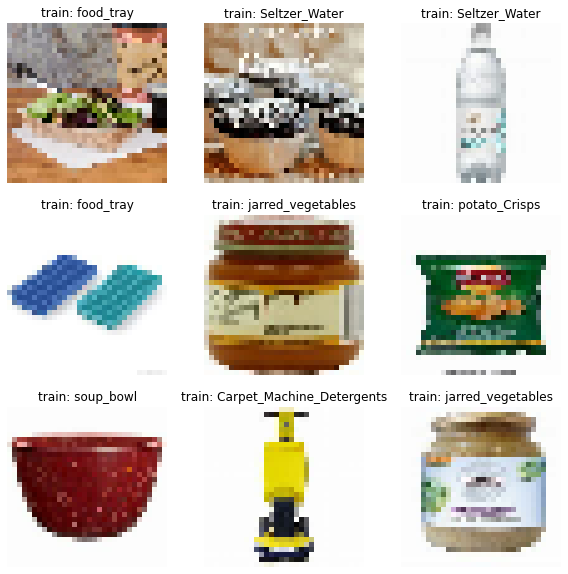

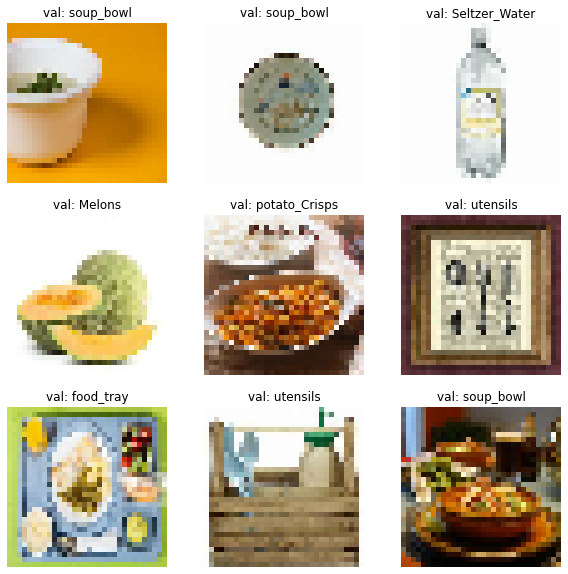

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("train: "+class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("val: "+class_names[labels[i]])
    plt.axis("off")

Building a model

In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

# single model
def CNN(input_shape, num_classes, base_width=16, depth=4):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width

    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
            
        x = MaxPool2D()(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=16, depth=4):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model

ens_dim = 3
model = Ensemble(ens_dim, (img_height, img_width, 3), len(class_names))
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 8)            101544      input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8)            101544      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 8)            101544      input_1[0][0]                    
Total params: 304,632
Trainable params: 304,632
Non-trainable params: 0
_____________

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

history = model.fit(
    n_train_ds, epochs=epochs, callbacks=callbacks, validation_data=n_val_ds,
)



Epoch 1/10
220/220 [==============================] - 2188s 10s/step - loss: 5.7745 - model_loss: 1.9196 - model_1_loss: 1.9369 - model_2_loss: 1.9180 - model_accuracy: 0.2251 - model_1_accuracy: 0.2171 - model_2_accuracy: 0.2254 - val_loss: 4.8523 - val_model_loss: 1.6321 - val_model_1_loss: 1.6122 - val_model_2_loss: 1.6079 - val_model_accuracy: 0.3479 - val_model_1_accuracy: 0.3929 - val_model_2_accuracy: 0.4049
Epoch 2/10
220/220 [==============================] - 16s 72ms/step - loss: 4.8477 - model_loss: 1.6117 - model_1_loss: 1.6332 - model_2_loss: 1.6029 - model_accuracy: 0.3742 - model_1_accuracy: 0.3623 - model_2_accuracy: 0.3907 - val_loss: 4.5123 - val_model_loss: 1.5382 - val_model_1_loss: 1.4977 - val_model_2_loss: 1.4763 - val_model_accuracy: 0.4374 - val_model_1_accuracy: 0.4647 - val_model_2_accuracy: 0.4590
Epoch 3/10
220/220 [==============================] - 16s 73ms/step - loss: 4.4418 - model_loss: 1.4836 - model_1_loss: 1.4823 - model_2_loss: 1.4759 - model_accur

Model saving:

In [ ]:
model.save("/content/drive/MyDrive/ML-HW2/ensemble_cnn.h5")

Now, we can load model from file:

In [ ]:
model1 = keras.models.load_model("/content/drive/MyDrive/ML-HW2/ensemble_cnn.h5")
model1.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 8)            101544      input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8)            101544      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 8)            101544      input_1[0][0]                    
Total params: 304,632
Trainable params: 304,632
Non-trainable params: 0
_____________

Single models test accuracy:  [0.5951024889945984, 0.589407742023468, 0.5831435322761536]
Ensemble test accuracy:  0.13496583143507973
              precision    recall  f1-score   support

           0       0.11      0.11      0.11       181
           1       0.16      0.19      0.17       239
           2       0.13      0.08      0.10       226
           3       0.13      0.11      0.12       227
           4       0.15      0.14      0.15       239
           5       0.12      0.10      0.11       195
           6       0.10      0.14      0.12       202
           7       0.17      0.17      0.17       247

    accuracy                           0.13      1756
   macro avg       0.13      0.13      0.13      1756
weighted avg       0.14      0.13      0.13      1756

[[20 29 23 30 22 17 23 22]
 [27 46 33 36 32 34 30 49]
 [12 20 19 20 25 18 17 18]
 [13 27 27 26 29 21 26 25]
 [26 24 25 28 34 33 25 31]
 [17 22 24 20 18 20 21 23]
 [47 33 37 34 51 32 29 36]
 [19 38 38 33 28 20 31 43

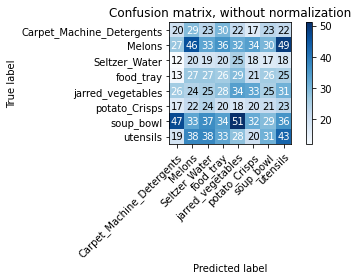

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

# accuracy
ind_test_acc = []
ind_test_acc_profile = []
for key in history.history.keys():
  if ("val" in key) and ("accuracy" in key):
    ind_test_acc.append(history.history[key][-1])
    ind_test_acc_profile.append(history.history[key])
print("Single models test accuracy: ", ind_test_acc)

# ensemble test accuracy
preds = np.array(model.predict(n_val_ds))
# average over the ensemble
preds_ens = np.mean(preds, axis=0)

predicted_categories = tf.argmax(preds_ens, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
ens_test_acc = accuracy_score(predicted_categories, true_categories)
print("Ensemble test accuracy: ", ens_test_acc)
print(classification_report(true_categories, predicted_categories))
print(confusion_matrix(predicted_categories, true_categories))

plot_confusion_matrix(predicted_categories, true_categories, class_names)

Text(0.5, 0, 'epoch')

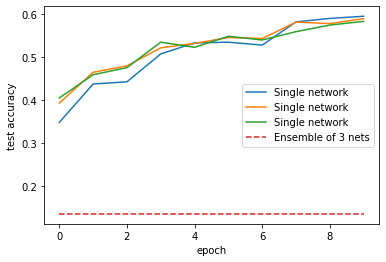

In [ ]:
plt.plot(np.transpose(ind_test_acc_profile), label="Single network")
plt.plot([ens_test_acc for _ in range(len(history.history[key]))], linestyle="--", label="Ensemble of {} nets".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')